In [68]:
%pip install pandas seaborn matplotlib statsmodels -Uq

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [50]:
df = pd.read_csv("./aux/pivo/datasets_56102_107707_monthly-beer-production-in-austr.csv")

In [51]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


# 0 — Препроцессинг

Преоборазуем строковую дату 'год-месяц' в индекс на основе timestamp

In [73]:
df["Month"] = pd.to_datetime(df["Month"], format="%Y-%m")
df = df.set_index('Month')
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


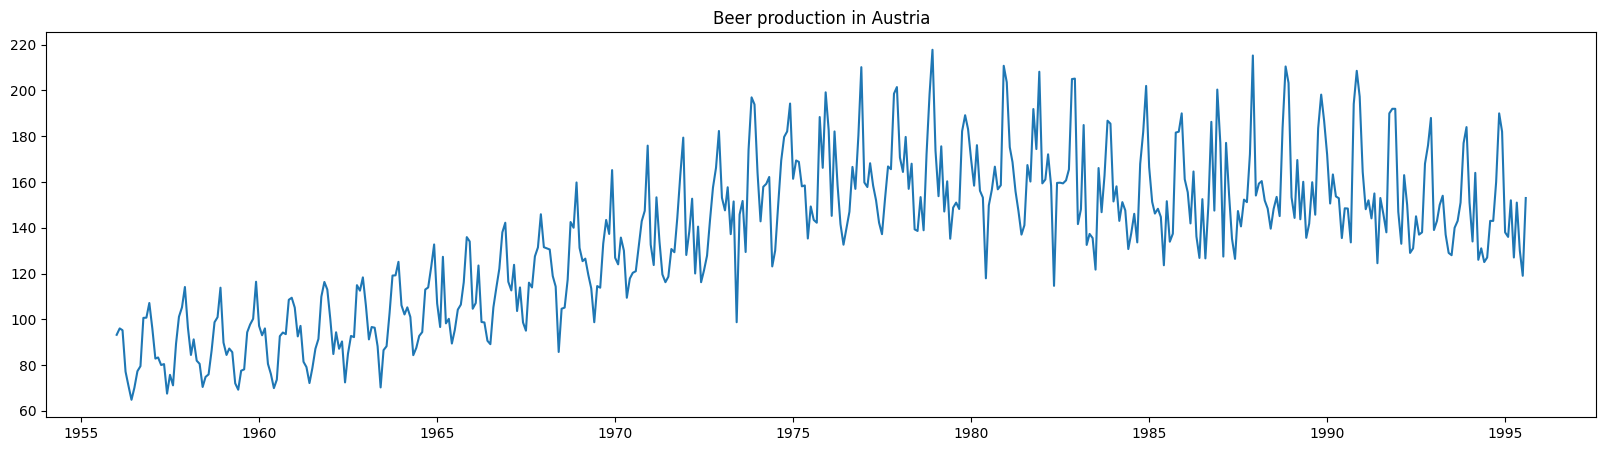

In [121]:
plt.figure(figsize=(20, 5))
plt.plot(df)
plt.title("Beer production in Austria")
plt.show()

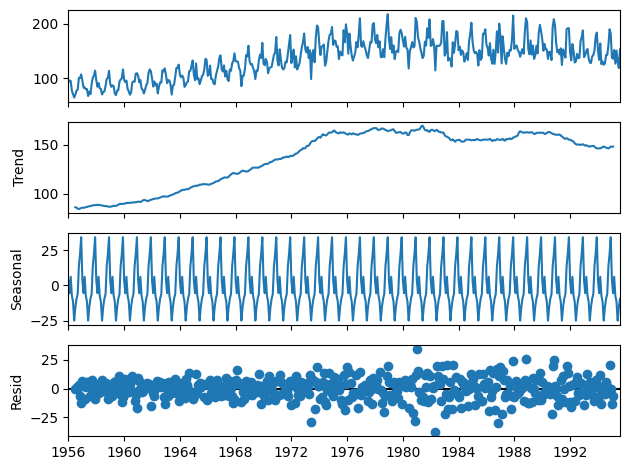

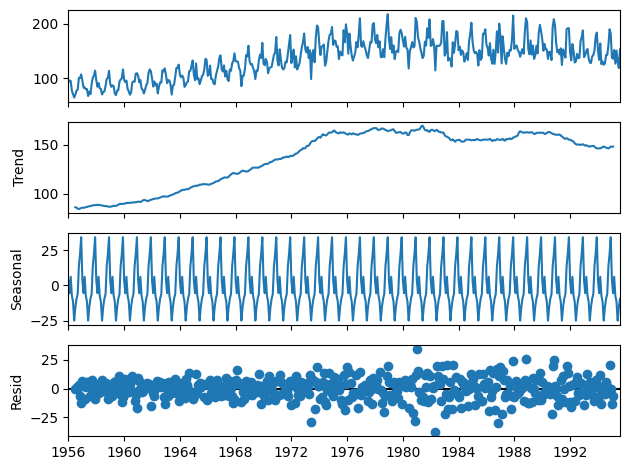

In [100]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df, model='additive')
result.plot()

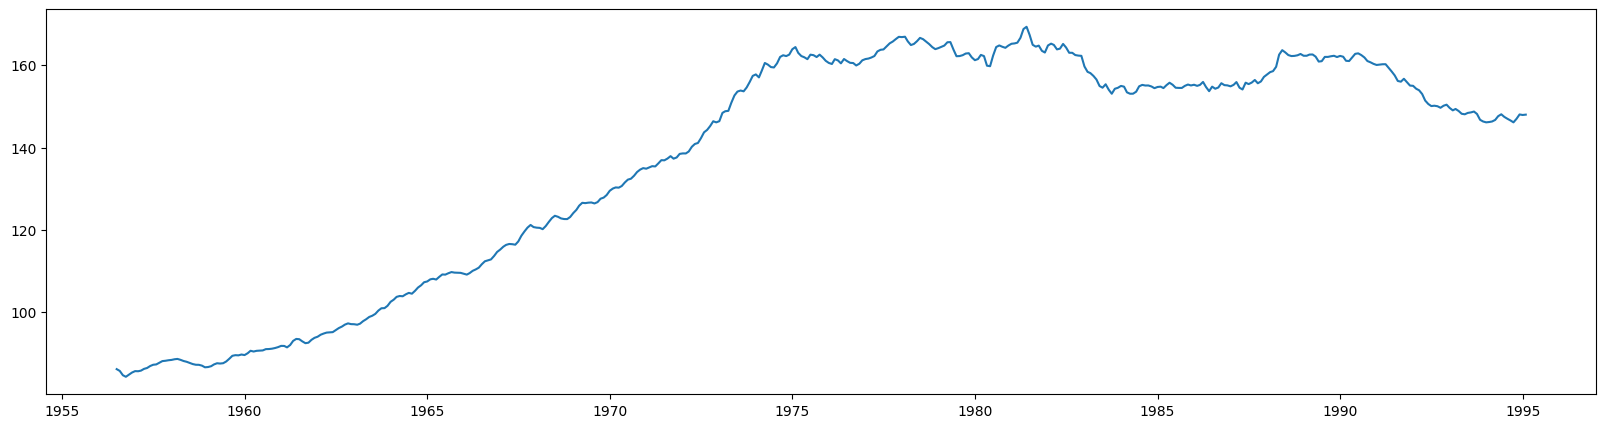

In [98]:
plt.figure(figsize=(20, 5))
plt.plot(result.trend)
plt.show()

### Общий тренд

Стремительный рост производства с 1960 по 1975 годы

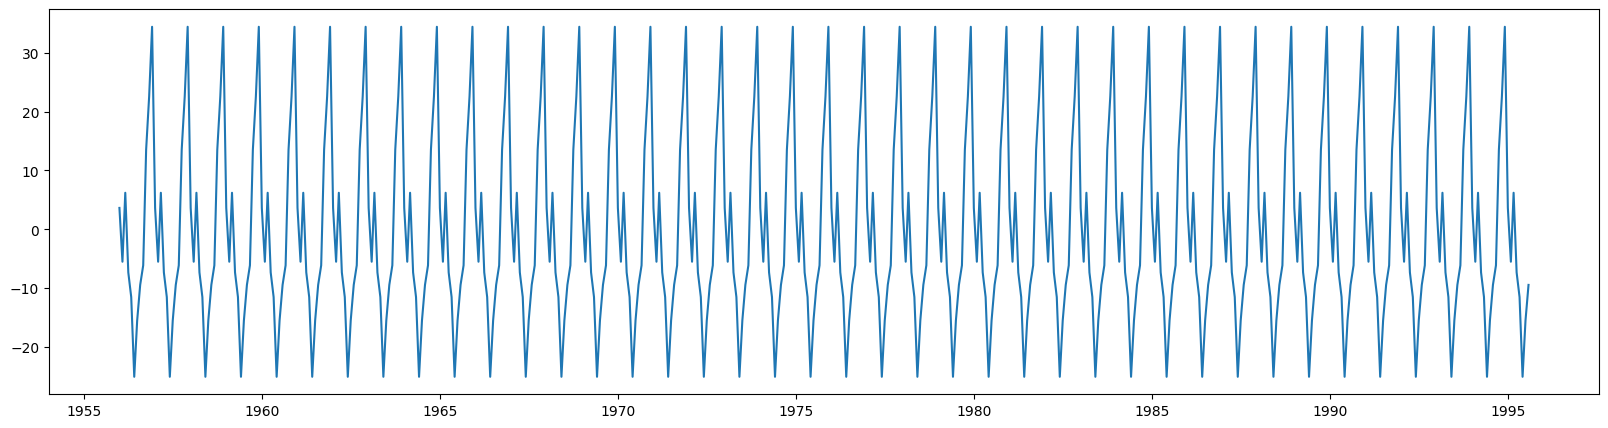

In [103]:
plt.figure(figsize=(20, 5))
plt.plot(result.seasonal)
plt.show()

### Сезонность в большем масштабе — с 1960–1965

Видно тренд на просадку производства к середине года (Май) и очень быстрый рост в третьем квартале

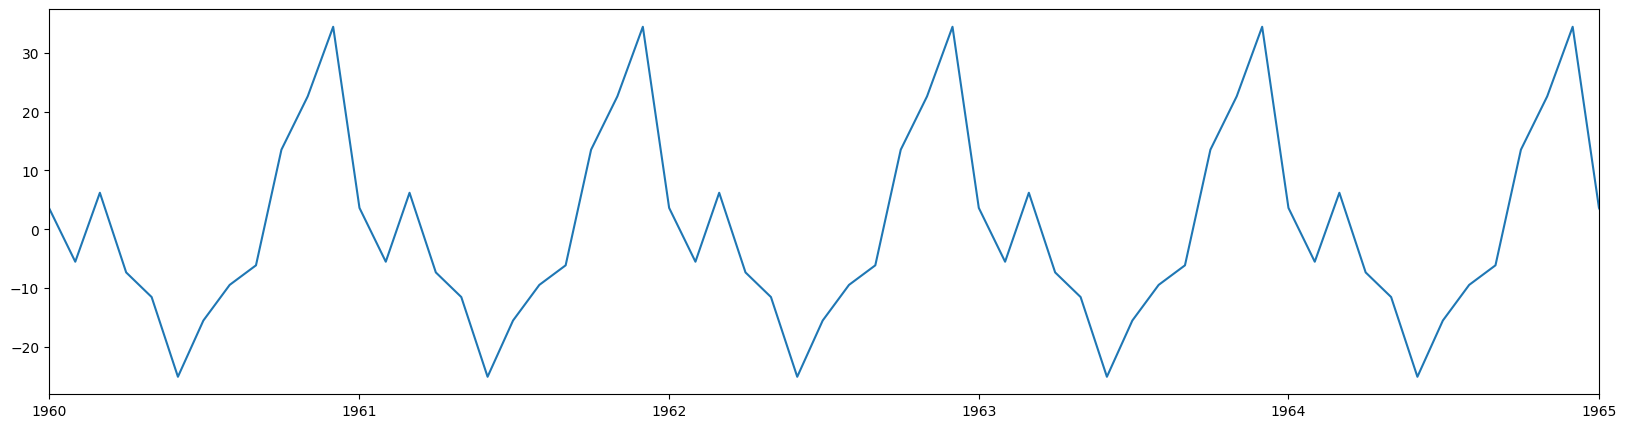

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(result.seasonal)
plt.xlim(pd.to_datetime('1960'), pd.to_datetime('1965'))
plt.show()

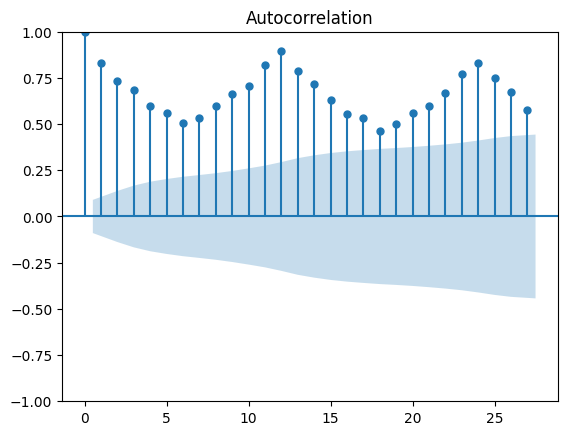

In [126]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df)
plt.show()

### Значения выходят за автокореляцию — тренд ясно выражен

# Логарифмирование и дифференцирование

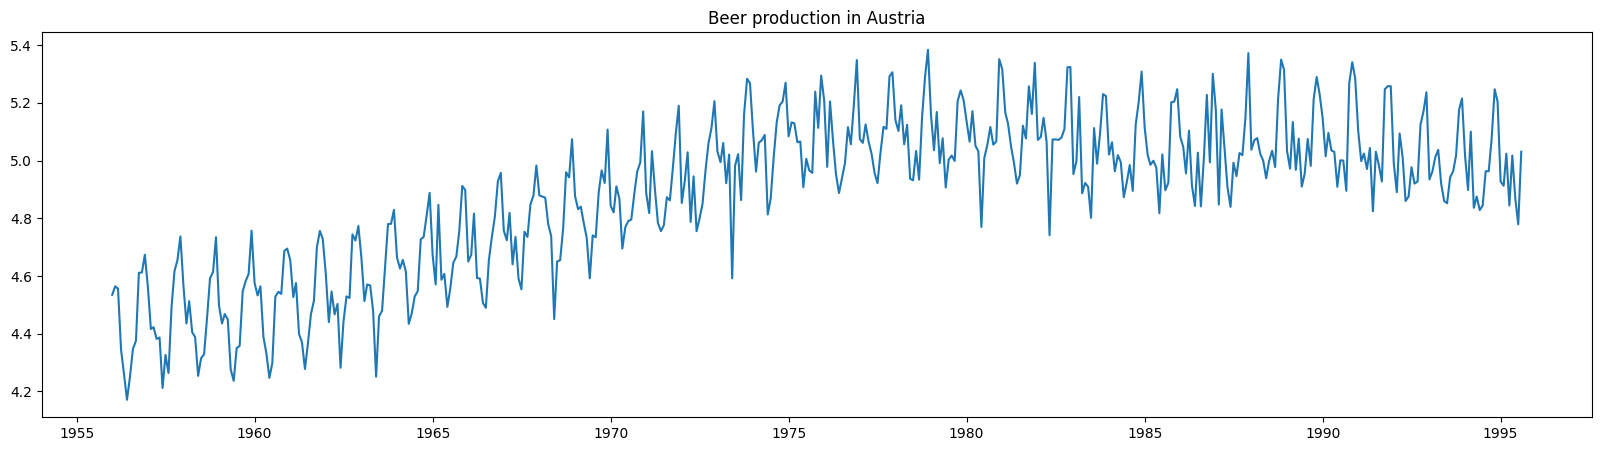

In [97]:
# Логарифмирование
plt.figure(figsize=(20, 5))
plt.plot(np.log(df))
plt.title("Beer production in Austria")
plt.show()

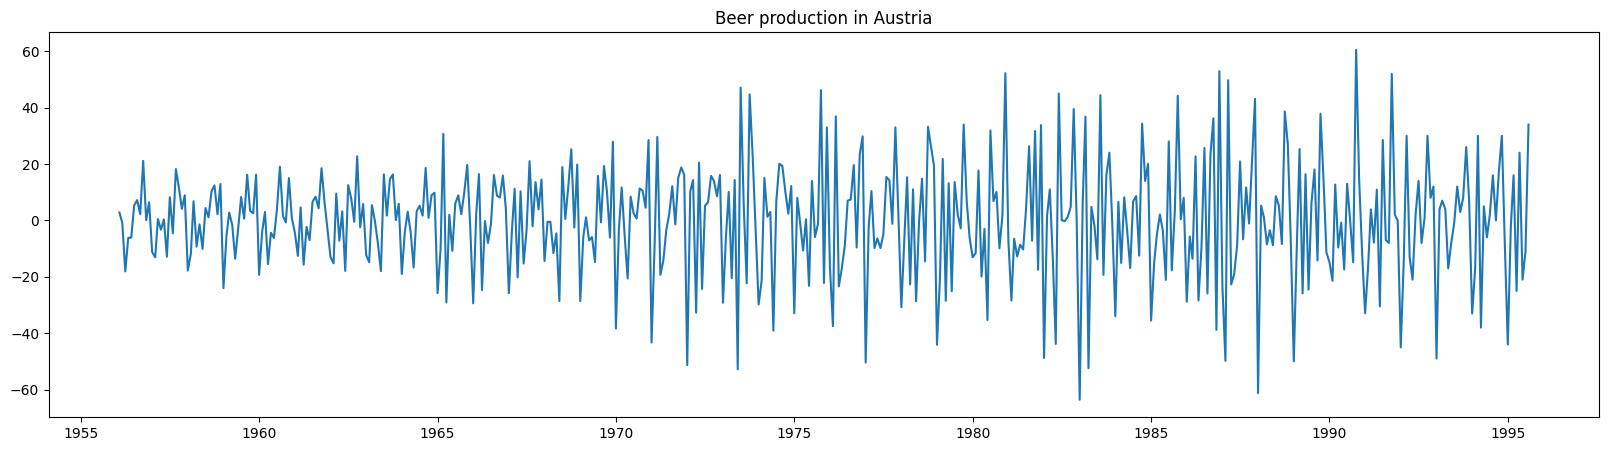

In [159]:
# Дифференцирование
plt.figure(figsize=(20, 5))
plt.plot(df["Monthly beer production"] - df["Monthly beer production"].shift(1))
plt.title("Beer production in Austria")
plt.show()

### Ряд не стационарен

Не наблюдается ковариации — значения сильно растут с 1965 года по 1990

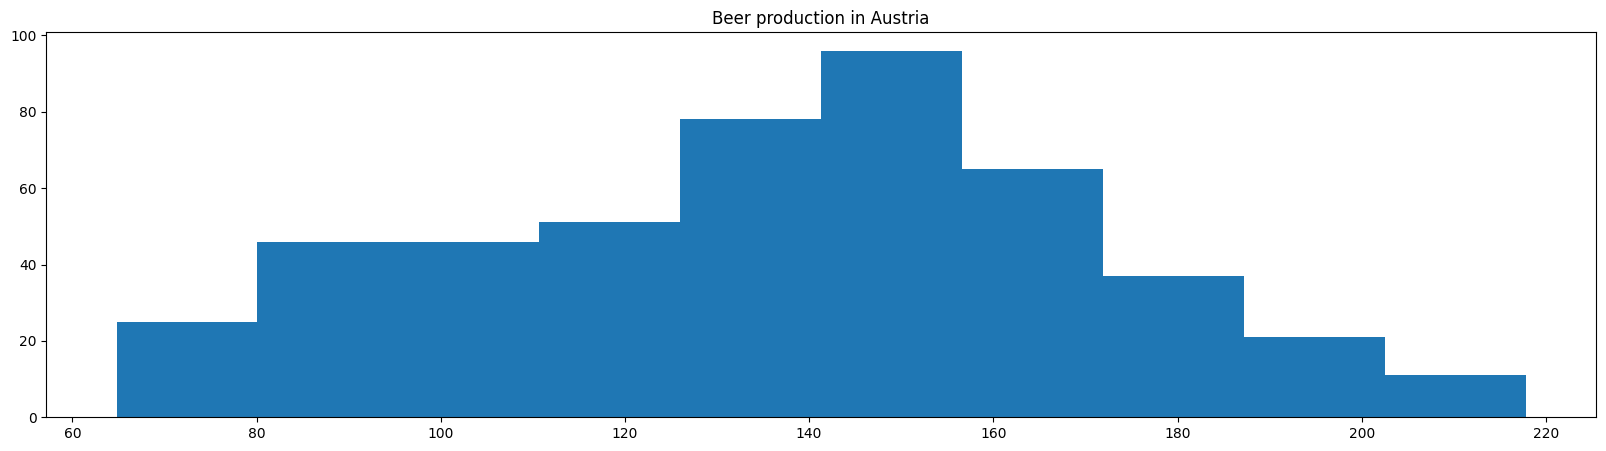

In [94]:
# Распределение производства пива
plt.figure(figsize=(20, 5))
plt.hist(df)
plt.title("Beer production in Austria")
plt.show()

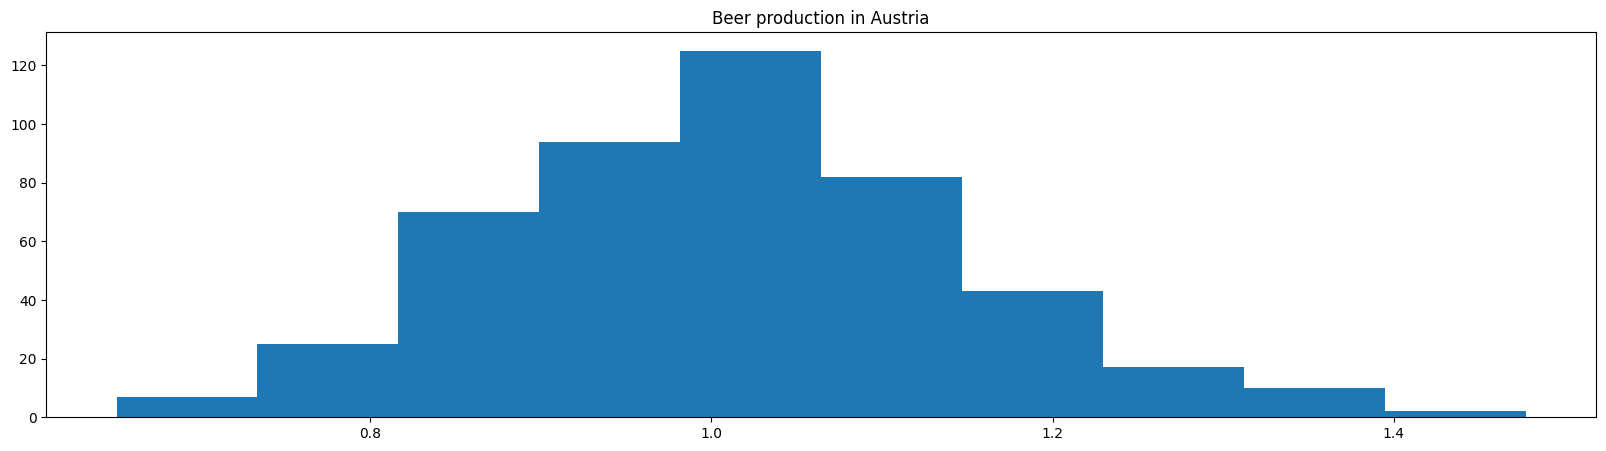

In [122]:
# Распределение смещения
plt.figure(figsize=(20, 5))
plt.hist(df/df.shift(1))
plt.title("Beer production in Austria")
plt.show()

# Извлечение характеристик и регрессия

## Модель Хольта-Уинтерса

In [ ]:
# Индексация датафрейма по месяцу
df.index.freq = 'MS'
# Установка периода и альфа
m = 12
alpha = 1/(2*m)

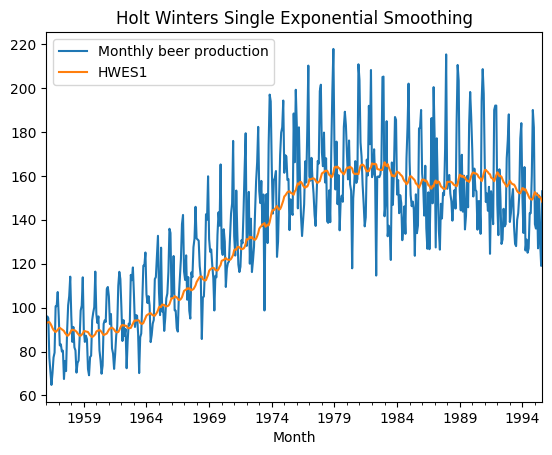

In [160]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 

df['HWES1'] = SimpleExpSmoothing(
    df['Monthly beer production']
).fit(
    smoothing_level=alpha,
    optimized=False,
    use_brute=True
).fittedvalues

df[['Monthly beer production','HWES1']].plot(
    title='Holt Winters Single Exponential Smoothing'
)

plt.show()

### Модель предсказывает лишь общий тренд

Что объяснимо, т.к. она лишь работает со значениями без учёта тренда и сезона

<Axes: title={'center': 'Хольт-Уинтерс — аддитивное/мультипликативное разложение'}, xlabel='Month'>

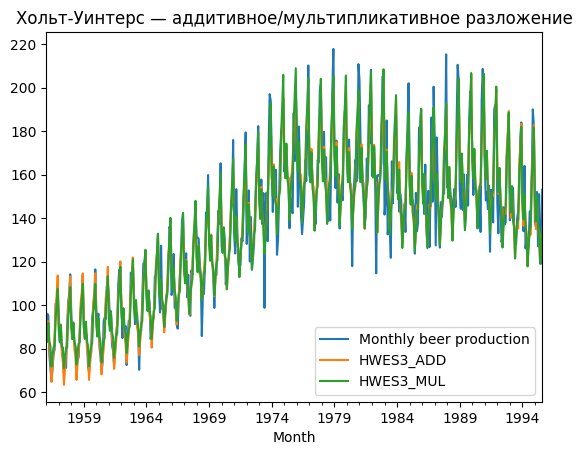

In [136]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df['HWES3_ADD'] = ExponentialSmoothing(
    df['Monthly beer production'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit().fittedvalues

df['HWES3_MUL'] = ExponentialSmoothing(
    df['Monthly beer production'],
    trend='mul',
    seasonal='mul',
    seasonal_periods=12
).fit().fittedvalues

df[['Monthly beer production','HWES3_ADD','HWES3_MUL']].plot(
    title='Хольт-Уинтерс — аддитивное/мультипликативное разложение')

### С учётом трендов и сезонов модель справляется лучше — особенно при мультипликативной декомпозиции (зелёный)

Это наблюдается ввиду того, что рост значений временного ряда стремителен

In [ ]:
train = df[:120]
test = df[120:]

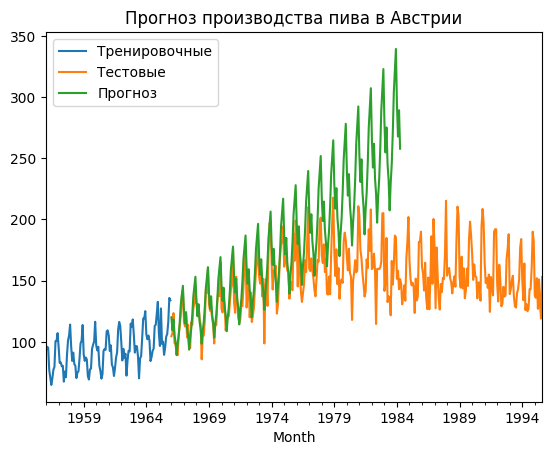

In [135]:
fitted_model = ExponentialSmoothing(
    train['Monthly beer production'], 
    trend='mul', 
    seasonal='mul',
    seasonal_periods=12 # год — 12 мес
).fit()
test_predictions = fitted_model.forecast(220)

train['Monthly beer production'].plot(legend=True, label='Тренировочные')
test['Monthly beer production'].plot(legend=True, label='Тестовые')
test_predictions.plot(legend=True, label='Прогноз')

plt.title('Прогноз производства пива в Австрии')
plt.show()

### Возможно слишком оптимистичные новости для австрийских производителей пива...

Но тренд на подъём модель предсказала

## Модель SARIMA

Модель требует стационарного временного ряда, поэтому дифференцируем датафрейм

In [138]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Monthly beer production'], autolag='AIC')
p_value = result[1]
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {p_value}')
print('Stationary' if p_value < 0.05 else 'Non-Stationary')

ADF Statistic: -2.282661418787578
p-value: 0.17762099829132466
Non-Stationary


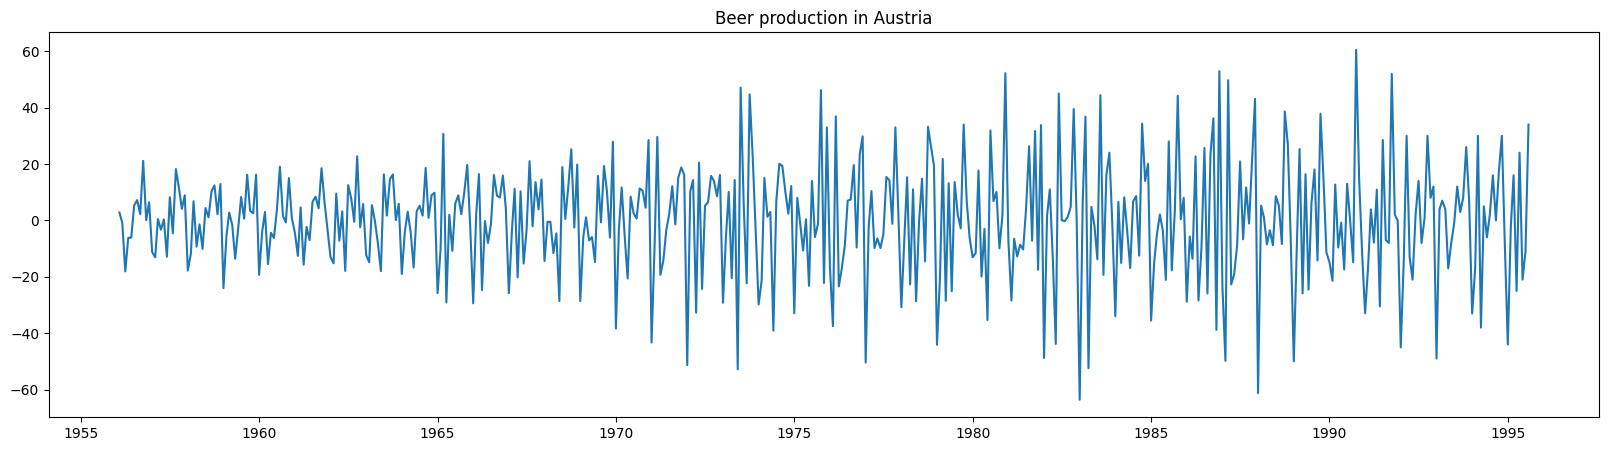

In [145]:
stdf = df['Monthly beer production']-df['Monthly beer production'].shift(1)
# Не забываем отблосить лаг
stdf.dropna(inplace=True)

plt.figure(figsize=(20, 5))
plt.plot(stdf)
plt.title("Beer production in Austria")
plt.show()

In [147]:
result = adfuller(stdf, autolag='AIC')
p_value = result[1]
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {p_value}')
print('Stationary' if p_value < 0.05 else 'Non-Stationary')

ADF Statistic: -4.980663743064772
p-value: 2.4234117859962812e-05
Stationary


### Обучаем модель SARIMA

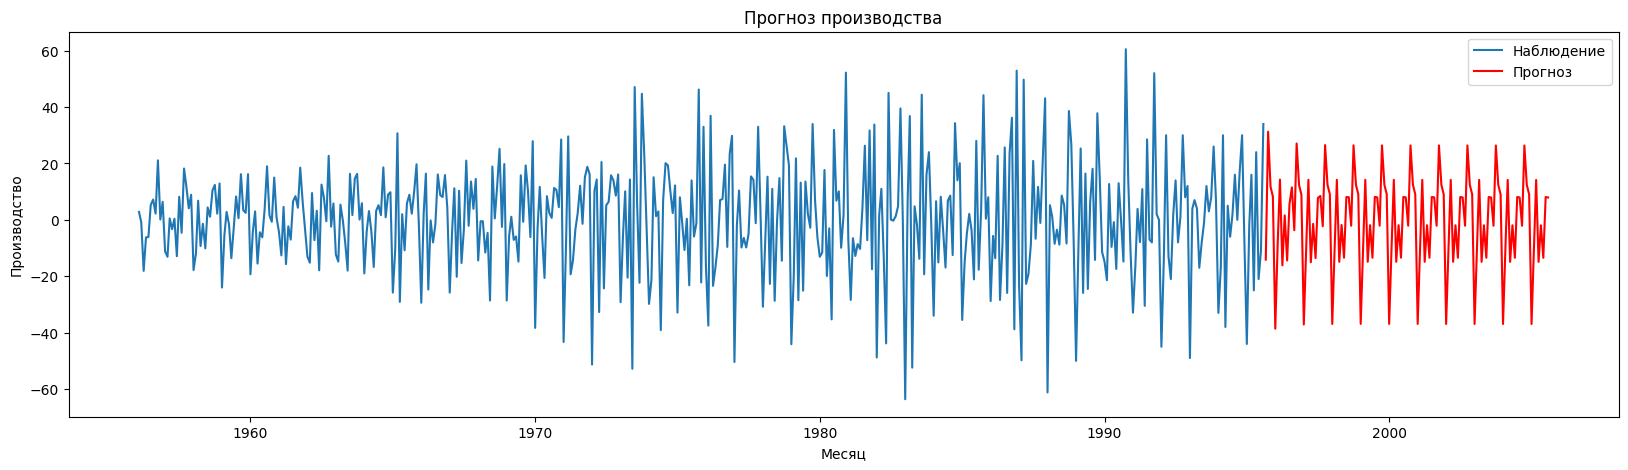

In [149]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(stdf, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

forecast_periods = 120
forecast = results.forecast(steps=forecast_periods)

plt.figure(figsize=(20, 5))
plt.plot(stdf, label='Наблюдение')
plt.plot(forecast, label='Прогноз', color='red')
plt.title('Прогноз производства')
plt.xlabel('Месяц')
plt.ylabel('Производство')
plt.legend()
plt.show()

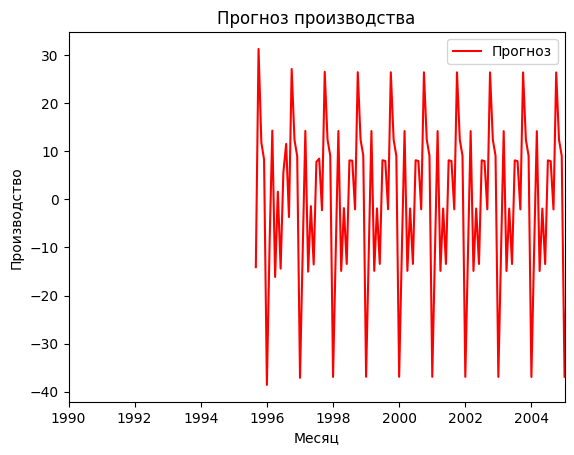

In [150]:
plt.plot(forecast, label='Прогноз', color='red')
plt.xlim(pd.to_datetime('1990'), pd.to_datetime('2005'))
plt.title('Прогноз производства')
plt.xlabel('Месяц')
plt.ylabel('Производство')
plt.legend()
plt.show()

### Модель увидела сезонность спадов и пиков производства

## Наивная модель на среднем значении

Используем тот же стационарный ряд и `rolling().mean()`

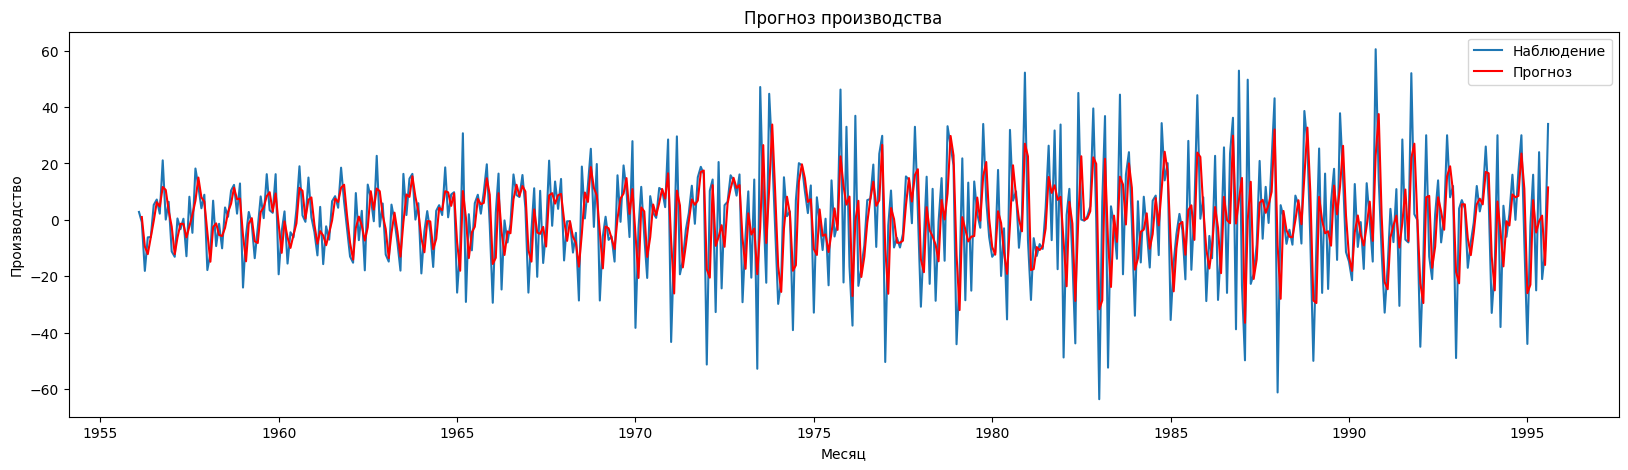

In [ ]:
forecast = stdf.rolling(2).mean() # Окно размером 2

plt.figure(figsize=(20, 5))
plt.plot(stdf, label='Наблюдение')
plt.plot(forecast, label='Прогноз', color='red')
plt.title('Прогноз производства')
plt.xlabel('Месяц')
plt.ylabel('Производство')
plt.legend()
plt.show()

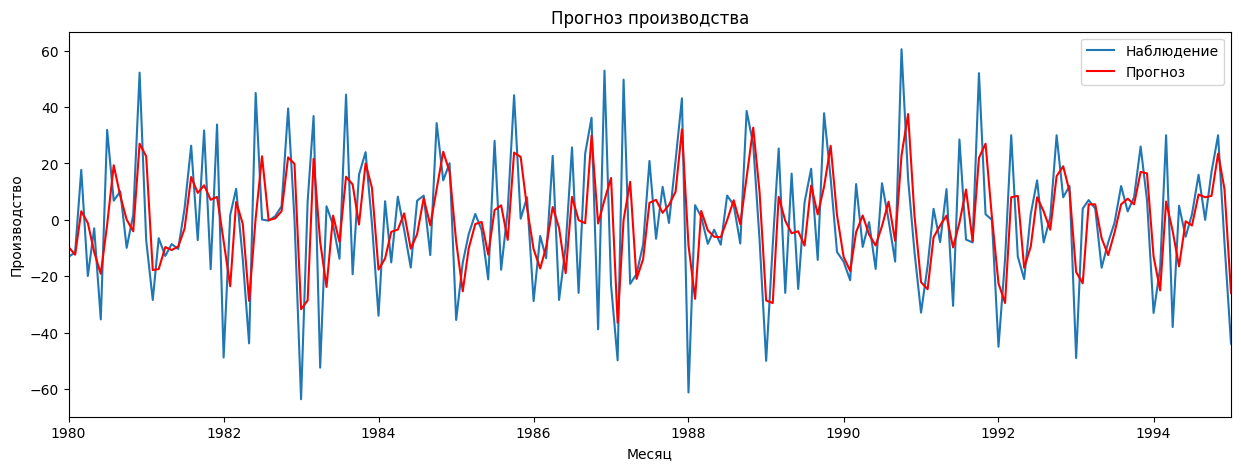

In [158]:
plt.figure(figsize=(15, 5))
plt.plot(stdf, label='Наблюдение')
plt.plot(forecast, label='Прогноз', color='red')
plt.xlim(pd.to_datetime('1980'), pd.to_datetime('1995'))
plt.title('Прогноз производства')
plt.xlabel('Месяц')
plt.ylabel('Производство')
plt.legend()
plt.show()

### Модель хорошо идёт по сезону, но по очевидным причинам не видит пики